In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import pandas as pd

# Bài toán 01A - Nạp dữ liệu train và test

## Nạp dữ liệu ảnh train và test

In [ ]:
import os
import numpy as np
import cv2

In [ ]:
# Hàm tải dữ liệu từ thư mục và chuyển đổi thành mảng ảnh
def load_images_from_folder(base_path, split):
    images = []
    labels = []

    split_folder = os.path.join(base_path, split)

    for class_name in os.listdir(split_folder):
        class_folder = os.path.join(split_folder, class_name)

        if os.path.isdir(class_folder):
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)

                # Đọc ảnh và chuyển đổi sang dạng mảng NumPy
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Chuyển đổi từ BGR sang RGB

                # Thêm ảnh và nhãn vào danh sách
                images.append(image)
                labels.append(class_name)  # Sử dụng tên thư mục làm nhãn

    # Chuyển thành mảng NumPy
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [ ]:
# Đường dẫn cơ bản đến thư mục dataset
base_path = '/content/drive/MyDrive/CS231/Đồ án/Thuoc/preprocessed'

# Tải dữ liệu từ thư mục train, valid và test
x_train, y_train = load_images_from_folder(base_path, 'train')
x_test, y_test = load_images_from_folder(base_path, 'test')

In [ ]:
print("Tập huấn luyện:", x_train.shape)
print("Tập kiểm tra:", x_test.shape)

Tập huấn luyện: (170, 512, 512, 3)
Tập kiểm tra: (30, 512, 512, 3)


## Hàm rút trích đặt trưng

In [ ]:
import numpy as np
import cv2
import pandas as pd

In [ ]:
from concurrent.futures import ThreadPoolExecutor
def Gabor_feature(img):
    freq = 0.1
    sigma = 3
    n_orientations = 8
    thetas = np.linspace(0, np.pi, n_orientations, endpoint=False)
    lambda_ = 1.0 / freq
    kernel_size = int(6 * sigma) | 1

    def process_theta(theta):
        kernel = cv2.getGaborKernel(
            (kernel_size, kernel_size), sigma, theta, lambda_, 0.5, 0, ktype=cv2.CV_32F
        )
        kernel /= np.linalg.norm(kernel)  # Chuẩn hóa kernel
        filtered = cv2.filter2D(img, cv2.CV_32F, kernel)
        return [filtered.mean(), filtered.std()]

    with ThreadPoolExecutor() as executor:
        features = list(executor.map(process_theta, thetas))

    return np.array(features).flatten()

## Rút trích đặc trưng ảnh train

In [ ]:
# Rút trích đặc trưng các ảnh dữ liệu train
x_train_features = []
y_train_labels = []
intAll = x_train.shape[0]
for i in range(intAll):
  x_train_features.append(Gabor_feature(x_train[i]))
  y_train_labels.append(y_train[i])

In [ ]:
#Lưu kết quả rút trích đặc trưng xuống
filename = '/content/drive/MyDrive/CS231/Đồ án/Thuoc_GaborFeature_Train.csv'
x_train_features = np.array(x_train_features)
y_train_labels = np.array(y_train_labels)
df_train = pd.DataFrame(x_train_features)
df_train.insert(0, 'label', y_train_labels)
df_train.to_csv(filename, index=False)

## Rút trích đặc trưng ảnh test

In [ ]:
# Rút trích đặc trưng các ảnh dữ liệu test
x_test_features = []
y_test_labels = []
intAll = x_test.shape[0]

for i in range(intAll):
 x_test_features.append(Gabor_feature(x_test[i]))
 y_test_labels.append(y_test[i])

In [ ]:
#Lưu kết quả rút trích đặc trưng xuống
filename = '/content/drive/MyDrive/CS231/Đồ án/Thuoc_GaborFeature_Test.csv'
x_test_features = np.array(x_test_features)
y_test_labels = np.array(y_test_labels)

df_test = pd.DataFrame(x_test_features)
df_test.insert(0, 'label', y_test_labels)
df_test.to_csv(filename, index=False)

# Bài toán 02 - Xây dựng model

## Nạp dữ liệu ảnh train

In [ ]:
#Đọc dữ liệu từ file csv có tên Thuoc_GaborFeature_Train.csv
filename = '/content/drive/MyDrive/CS231/Đồ án/Thuoc_GaborFeature_Train.csv'

print("Đang đọc file dữ liệu...")
df_train = pd.read_csv(filename)
X_train = df_train.iloc[:, 1:].values  # Đặc trưng
y_train = df_train.iloc[:, 0].values  # Nhãn
print("Đọc xong!!!")

Đang đọc file dữ liệu...
Đọc xong!!!


## Nạp dữ liệu ảnh test

In [ ]:
# Nạp dữ liệu ảnh test của bài toán phân lớp ảnh.
filename = '/content/drive/MyDrive/CS231/Đồ án/Thuoc_GaborFeature_Test.csv'

print("Đang đọc file dữ liệu...")
df_test = pd.read_csv(filename)
X_test = df_test.iloc[:,1:].values
y_test = df_test.iloc[:,0].values
print("Đọc xong!!!")

Đang đọc file dữ liệu...
Đọc xong!!!


## Chuẩn hóa tập huấn luyện và kiểm tra

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [ ]:
# Bước 1: Nạp dữ liệu
# Bước 2: Chuẩn hóa dữ liệu (SVM yêu cầu dữ liệu chuẩn hóa)
scaler = StandardScaler()

In [ ]:
# Chuẩn hóa tập huấn luyện và tập kiểm tra
X_train_scaled = scaler.fit_transform(X_train)  # Chuẩn hóa tập huấn luyện
X_test_scaled = scaler.transform(X_test)  # Chuẩn hóa tập kiểm tra

## Plot dữ liệu được rút trích từ ảnh Train

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

In [ ]:
# Encode the labels to numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)

In [ ]:
# # Giảm số chiều về 2 với PCA
# pca = PCA(n_components=2)
# X_reduced = pca.fit_transform(X_train_scaled)

# fig, ax = plt.subplots(figsize=(6, 5))

# # Điều chỉnh giới hạn trục sao cho phù hợp với dữ liệu
# ax.set(xlim=(np.min(X_reduced[:, 0]) - 10, np.max(X_reduced[:, 0]) + 10),
#        ylim=(np.min(X_reduced[:, 1]) - 10, np.max(X_reduced[:, 1]) + 10))

# bright_colors = ['#D62728', '#1F77B4', '#2CA02C', '#FF7F0E', '#9467BD']

# # Giảm kích thước các điểm và thêm lưới
# # scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], s=50, c=y_encoded, cmap='viridis', edgecolors="k", alpha=0.7)
# # Scatter points
# scatter = ax.scatter(
#     X_reduced[:, 0], X_reduced[:, 1],
#     c=y_encoded, cmap=ListedColormap(bright_colors),
#     edgecolor='k', s=60, alpha=0.9
# )

# # Thêm lưới và điều chỉnh kiểu hiển thị
# ax.grid(True)
# ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")

# ax.set_title("Gabor feature")
# plt.show()

## Áp dụng GridSearchCV

In [ ]:
# Bước 3: Định nghĩa mô hình SVM
svm = SVC()

In [ ]:
# Bước 4: Định nghĩa tham số cần tìm kiếm (các siêu tham số của SVM)
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Bước 5: Tạo GridSearchCV để tìm kiếm tham số tốt nhất
grid = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)

# Bước 6: Huấn luyện mô hình với GridSearchCV
grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             verbose=1)

In [ ]:
# Bước 7: In ra tham số tốt nhất và điểm kiểm tra (best score)
print("Best parameters found: ", grid.best_params_)
print("Best cross-validation accuracy: ", grid.best_score_)

Best parameters found:  {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation accuracy:  0.7764705882352941


In [ ]:
# Lưu mô hình với tham số tốt nhất
import pickle

best_model = grid.best_estimator_
# Lưu mô hình đã huấn luyện xuống file .pkl
model_filename = '/content/drive/MyDrive/CS231/Đồ án/Gabor_svm_model.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(best_model, model_file)

print(f"Mô hình đã được lưu xuống: {model_filename}")

Mô hình đã được lưu xuống: /content/drive/MyDrive/CS231/Đồ án/Gabor_svm_model.pkl


## Plot tập rút trích của tập train sau khi qua mô hình SVM với kernel tốt nhất

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [ ]:
# # 1. Giảm chiều dữ liệu xuống 2D với PCA
# pca = PCA(n_components=2)
# X_reduced = pca.fit_transform(X_train_scaled)

# # 2. Load SVM best_params từ file lưu mô hình
# with open('/content/drive/MyDrive/CS231/Đồ án/Gabor_svm_model.pkl', 'rb') as f:
#     best_svm = pickle.load(f)
# best_params = best_svm.get_params()

# # 3. Khởi tạo và huấn luyện SVM trên không gian 2D
# tsvm = SVC(**best_params)
# tsvm.fit(X_reduced, y_encoded)

# # 4. Tạo lưới cho decision boundary
# x_min, x_max = X_reduced[:, 0].min() - 10, X_reduced[:, 0].max() + 10
# y_min, y_max = X_reduced[:, 1].min() - 10, X_reduced[:, 1].max() + 10
# xx, yy = np.meshgrid(
#     np.linspace(x_min, x_max, 500),
#     np.linspace(y_min, y_max, 500)
# )
# grid = np.c_[xx.ravel(), yy.ravel()]

# # 5. Dự đoán nhãn trên lưới
# Z = tsvm.predict(grid).reshape(xx.shape)

# # 6. Vẽ scatter + decision boundary với legend góc trên phải hiển thị chỉ số lớp
# fig, ax = plt.subplots(figsize=(6, 5))

# # Vùng phân lớp
# bright_colors = ['#D62728', '#1F77B4', '#2CA02C', '#FF7F0E', '#9467BD']
# cmap_light = ListedColormap(bright_colors)
# ax.contourf(xx, yy, Z, alpha=0.2, cmap=cmap_light)

# # Scatter points
# scatter = ax.scatter(
#     X_reduced[:, 0], X_reduced[:, 1],
#     c=y_encoded, cmap=ListedColormap(bright_colors),
#     edgecolor='k', s=60, alpha=0.9
# )

# # Legend hiển thị chỉ số lớp
# ax.legend(*scatter.legend_elements(), loc='upper right', title='Class Index')

# # Cấu hình trục, lưới và tiêu đề
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
# ax.grid(True, linestyle='--', linewidth=0.5)
# ax.set_title("Gabor feature with SVM {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'} Decision Boundary")

# plt.tight_layout()
# plt.show()

# Bài toán 03 - Kiểm thử model

## Kiểm thử model với tập test

In [ ]:
import pickle
filename = "/content/drive/MyDrive/CS231/Đồ án/Gabor_svm_model.pkl"
with open(filename, 'rb') as file:
 model = pickle.load(file)

In [ ]:
# Lấy ngẫu nhiên một ảnh từ tập dữ liệu test và sử dụng model để predict (phân lớp)
import numpy as np
import random
index = random.randrange(x_test.shape[0])
y_pred = model.predict(X_test[index:index+1])

In [ ]:
import os
from glob import glob
image_path = "/content/drive/MyDrive/CS231/Đồ án/Thuoc/preprocessed/test/betaloc_50_mg/038.png"
# Tạo danh sách đường dẫn ảnh test
test_dir = "/content/drive/MyDrive/CS231/Đồ án/Thuoc/preprocessed/test"
# X_test_paths = sorted(glob(os.path.join(test_dir, "*", "*.png")))  # tìm trong các thư mục con
X_test_paths = (glob(os.path.join(test_dir, "*", "*.png")))

# Tìm chỉ số của ảnh này trong danh sách đường dẫn
index = X_test_paths.index(image_path)

# Dự đoán ảnh tại chỉ số đó
y_pred = model.predict(X_test_scaled[index:index+1])

Text(0.5, 1.0, 'Label predict:betaloc_50_mg(24)')

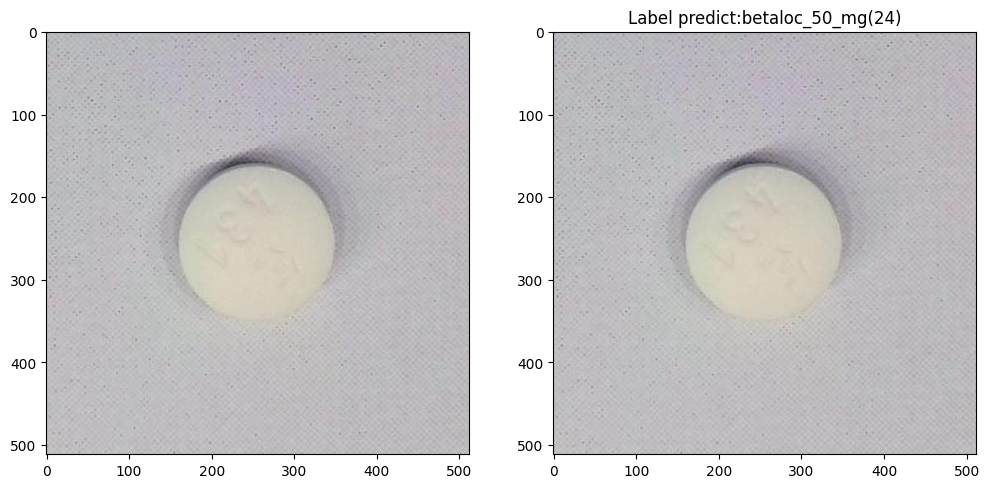

In [ ]:
#Trực quan hoá dữ liệu gốc (ảnh + nhãn) và kết quả dự đoán (predict)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(x_test[index], cmap='Greys')
# strTitle = 'Label:'
# strTitle = strTitle + format(y_test[index])
# strTitle = strTitle + '('+ format(index)+')'
# plt.title(strTitle)

plt.subplot(1,2,2)
plt.imshow(x_test[index], cmap='Greys')
strTitle = 'Label predict:'
strTitle = strTitle + format(y_pred[0])
strTitle = strTitle + '('+ format(index)+')'
plt.title(strTitle)

## Kiểm thử model với ảnh bên ngoài

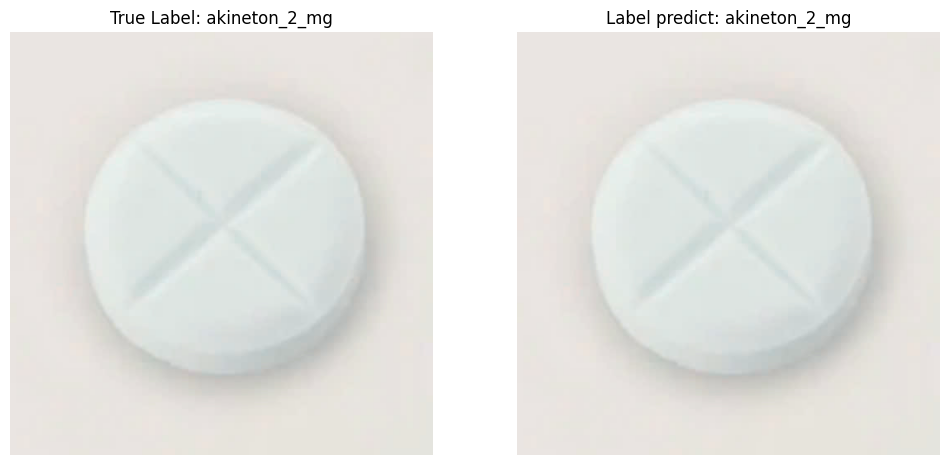

In [ ]:
import matplotlib.pyplot as plt
# Đọc hình ảnh mới (không phải từ tập train/test)
image_path = "/content/drive/MyDrive/CS231/Đồ án/Test_Anh_Ngoai/akineton_2_mg_0.png"
# image_path="/content/drive/MyDrive/CS231/Đồ án/Thuoc/test/akineton_2_mg/036.png"
image = cv2.imread(image_path)  # Đọc ảnh ở định dạng grayscale

# Rút trích đặc trưng LBP từ ảnh
gabor_features = Gabor_feature(np.array(image))

# Chuẩn hóa đặc trưng LBP (giả sử bạn đã chuẩn hóa trên tập train)
gabor_features_scaled = scaler.transform(gabor_features.reshape(1, -1))  # Dùng transform thay vì fit_transform

# Dự đoán nhãn cho ảnh mới
y_pred = model.predict(gabor_features_scaled)

plt.figure(figsize=(12,12))
plt.subplot(1, 2, 1)
plt.imshow(image)  # Hiển thị ảnh màu
plt.title(f"True Label: akineton_2_mg")
plt.axis('off')

# Trực quan hóa kết quả
plt.subplot(1, 2, 2)
plt.imshow(image)  # Hiển thị ảnh gốc
plt.title(f"Label predict: {y_pred[0]}")
plt.axis('off')
plt.show()

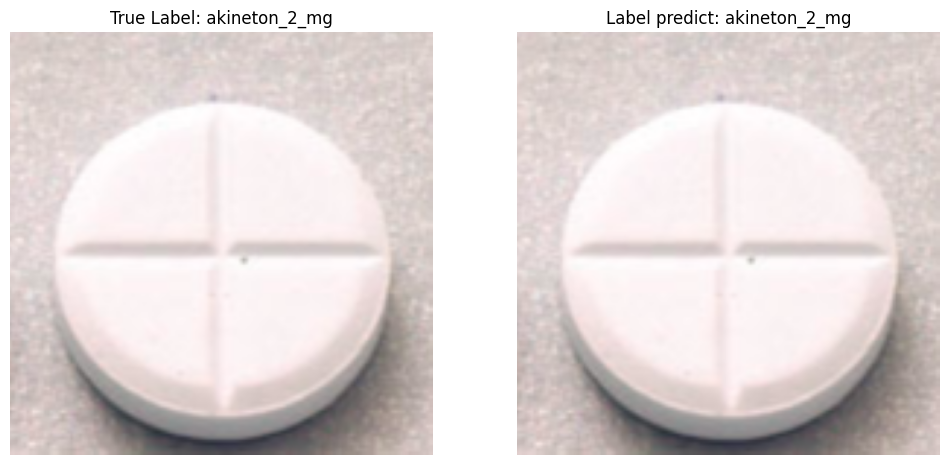

In [ ]:
import matplotlib.pyplot as plt

# Đọc hình ảnh mới (không phải từ tập train/test)
image_path = "/content/drive/MyDrive/CS231/Đồ án/Test_Anh_Ngoai/akineton_2_mg_2.png"
# image_path="/content/drive/MyDrive/CS231/Đồ án/Thuoc/test/akineton_2_mg/036.png"
image = cv2.imread(image_path)  # Đọc ảnh ở định dạng grayscale

# Rút trích đặc trưng LBP từ ảnh
gabor_features = Gabor_feature(np.array(image))

# Chuẩn hóa đặc trưng LBP (giả sử bạn đã chuẩn hóa trên tập train)
gabor_features_scaled = scaler.transform(gabor_features.reshape(1, -1))  # Dùng transform thay vì fit_transform

# Dự đoán nhãn cho ảnh mới
y_pred = model.predict(gabor_features_scaled)

plt.figure(figsize=(12,12))
plt.subplot(1, 2, 1)
plt.imshow(image)  # Hiển thị ảnh màu
plt.title(f"True Label: akineton_2_mg")
plt.axis('off')

# Trực quan hóa kết quả
plt.subplot(1, 2, 2)
plt.imshow(image)  # Hiển thị ảnh gốc
plt.title(f"Label predict: {y_pred[0]}")
plt.axis('off')
plt.show()

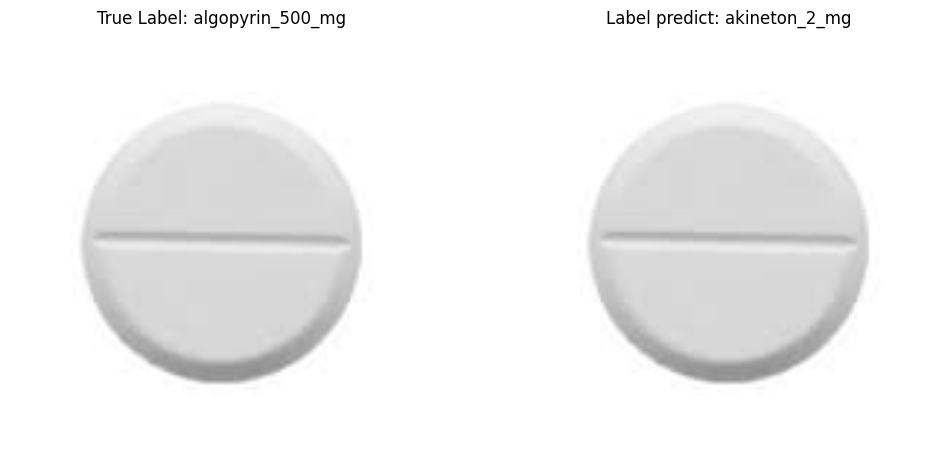

In [ ]:
import matplotlib.pyplot as plt

# Đọc hình ảnh mới (không phải từ tập train/test)
image_path = "/content/drive/MyDrive/CS231/Đồ án/Test_Anh_Ngoai/algopyrin_500_mg_1.png"
# image_path="/content/drive/MyDrive/CS231/Đồ án/Thuoc/test/akineton_2_mg/036.png"
image = cv2.imread(image_path)  # Đọc ảnh ở định dạng grayscale

# Rút trích đặc trưng LBP từ ảnh
gabor_features = Gabor_feature(np.array(image))

# Chuẩn hóa đặc trưng LBP (giả sử bạn đã chuẩn hóa trên tập train)
gabor_features_scaled = scaler.transform(gabor_features.reshape(1, -1))  # Dùng transform thay vì fit_transform

# Dự đoán nhãn cho ảnh mới
y_pred = model.predict(gabor_features_scaled)

plt.figure(figsize=(12,12))
plt.subplot(1, 2, 1)
plt.imshow(image)  # Hiển thị ảnh màu
plt.title(f"True Label: algopyrin_500_mg")
plt.axis('off')

# Trực quan hóa kết quả
plt.subplot(1, 2, 2)
plt.imshow(image)  # Hiển thị ảnh gốc
plt.title(f"Label predict: {y_pred[0]}")
plt.axis('off')
plt.show()

# Bài toán 05 - Đánh giá model tốt nhất trên tập test

In [ ]:
from skimage import io
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
import pickle
# Đọc mô hình
filename = "/content/drive/MyDrive/CS231/Đồ án/Gabor_svm_model.pkl"
with open(filename, 'rb') as file:
 model = pickle.load(file)

In [ ]:
#Dự đoán kết quả của toàn bộ tập dữ liệu test
y_pred = model.predict(X_test_scaled)

In [ ]:
# Thực hiện classification report và lưu kết quả xuống tập tin csv
# Thuoc_GaborFeatureSVMReport_Test_best_degree5.csv
from sklearn.metrics import classification_report
filename = '/content/drive/MyDrive/CS231/Đồ án/report.csv'
report = classification_report(y_test, y_pred, output_dict=True)

report = pd.DataFrame(report).transpose()
report.to_csv(filename, index=False)
print(report)

                         precision    recall  f1-score    support
akineton_2_mg             1.000000  1.000000  1.000000   6.000000
algopyrin_500_mg          1.000000  1.000000  1.000000   6.000000
ambroxol_egis_30_mg       0.833333  0.833333  0.833333   6.000000
atorvastatin_teva_20_mg   1.000000  1.000000  1.000000   6.000000
betaloc_50_mg             0.833333  0.833333  0.833333   6.000000
accuracy                  0.933333  0.933333  0.933333   0.933333
macro avg                 0.933333  0.933333  0.933333  30.000000
weighted avg              0.933333  0.933333  0.933333  30.000000


In [ ]:
# Tính các độ đo trên tập test
accuracy_test = accuracy_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall_test = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1_test = f1_score(y_test, y_pred, average='weighted', zero_division=1)

print(f"Test Accuracy: {accuracy_test * 100:.4f}%")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall: {recall_test:.4f}")
print(f"Test F1 Score: {f1_test:.4f}")

Test Accuracy: 93.3333%
Test Precision: 0.9333
Test Recall: 0.9333
Test F1 Score: 0.9333


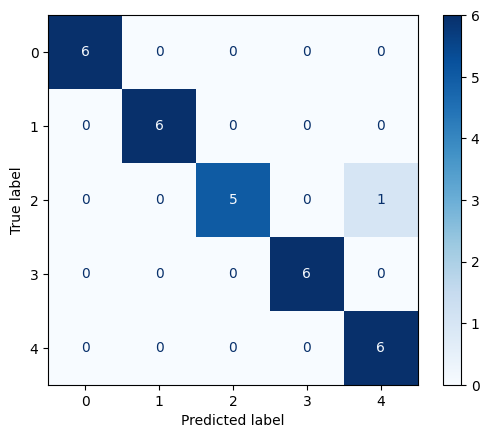

In [ ]:
# Xuất confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
# Display the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## In ra các hình ảnh phân loại sai

In [ ]:
# 1. Xác định các chỉ số bị phân loại sai
mis_idx = np.where(y_pred != y_test)[0]
print(f"Total misclassified: {len(mis_idx)} / {len(y_test)}")

Total misclassified: 1 / 30


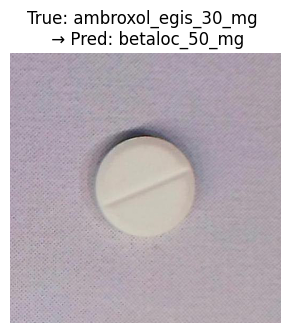

In [ ]:
# 2. Hiển thị một số ảnh sai (ví dụ 16 ảnh đầu)
num_to_show = min(16, len(mis_idx))
plt.figure(figsize=(12,12))

for i, idx in enumerate(mis_idx[:num_to_show]):
    plt.subplot(4, 4, i+1)
    # Hiển thị ảnh gốc
    plt.imshow(x_test[idx], cmap=None)   # nếu ảnh màu dùng cmap=None
    plt.title(f"True: {y_test[idx]} \n → Pred: {y_pred[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Bài toán 06: thử kết quả trên cấu hình {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

## Huấn luyện mô hình

In [ ]:
# Bước 2: Chuẩn hóa dữ liệu (SVM yêu cầu dữ liệu chuẩn hóa)
scaler = StandardScaler()

In [ ]:
# Chuẩn hóa tập huấn luyện và tập kiểm tra
X_train_scaled = scaler.fit_transform(X_train)  # Chuẩn hóa tập huấn luyện
X_test_scaled = scaler.transform(X_test)  # Chuẩn hóa tập kiểm tra

In [ ]:
from sklearn.svm import SVC

# Huấn luyện mô hình SVM (hoặc mô hình khác)
svm = SVC(kernel='linear', gamma = 'scale', C=0.1)
svm.fit(X_train_scaled, y_train)

SVC(C=0.1, kernel='linear')

## Plot tập rút trích của tập train sau khi qua mô hình SVM với kernel {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.decomposition import PCA
# from sklearn.svm import SVC

# # Giả sử bạn đã có X_train, y_train, X_test, y_test
# # Mã hóa nhãn nếu cần
# # label_encoder = LabelEncoder().fit(y_train)
# y_encoded = LabelEncoder().fit_transform(y_train)

# # 1. Chuẩn hóa dữ liệu
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # 2. PCA xuống 2D
# pca = PCA(n_components=2)
# X_train_2d = pca.fit_transform(X_train_scaled)

# # 3. Huấn luyện SVM với cấu hình cố định
# params = {'C': 0.1, 'kernel': 'linear', 'gamma': 'scale'}
# svm = SVC(**params)
# svm.fit(X_train_2d, y_encoded)

# # 4. Tạo lưới để vẽ decision boundary
# x_min, x_max = X_train_2d[:,0].min() - 10, X_train_2d[:,0].max() + 10
# y_min, y_max = X_train_2d[:,1].min() - 10, X_train_2d[:,1].max() + 10
# xx, yy = np.meshgrid(
#     np.linspace(x_min, x_max, 500),
#     np.linspace(y_min, y_max, 500)
# )
# grid = np.c_[xx.ravel(), yy.ravel()]

# # 5. Dự đoán nhãn trên lưới
# Z = svm.predict(grid).reshape(xx.shape)

# # 6. Plot decision boundary và scatter
# fig, ax = plt.subplots(figsize=(6,5))

# # Màu sắc
# colors = ['#D62728', '#1F77B4', '#2CA02C', '#FF7F0E', '#9467BD']
# cmap_light = ListedColormap(colors)

# # Vùng phân lớp
# ax.contourf(xx, yy, Z, alpha=0.2, cmap=cmap_light)

# # Scatter
# scatter = ax.scatter(
#     X_train_2d[:,0], X_train_2d[:,1],
#     c=y_encoded, cmap=ListedColormap(colors),
#     edgecolor='k', s=60, alpha=0.9
# )

# # Legend chỉ số lớp
# ax.legend(*scatter.legend_elements(), loc='upper right', title='Class')

# # Thiết lập
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
# ax.set_title("Gabor feature with SVM {C=0.1, kernel='linear', gamma='scale') Decision Boundary")
# ax.grid(True, linestyle='--', linewidth=0.5)
# plt.tight_layout()
# plt.show()

## Kiểm thử kết quả trên tập train

In [ ]:
# Dự đoán trên tập train
# Use X_train_2d (the 2D data used for training) for prediction
y_pred = svm.predict(X_train_scaled)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# In classification report
print(classification_report(y_train, y_pred)) # y_train and y_pred should now have the same type

                         precision    recall  f1-score   support

          akineton_2_mg       0.50      0.65      0.56        34
       algopyrin_500_mg       1.00      0.97      0.99        34
    ambroxol_egis_30_mg       0.52      0.44      0.48        34
atorvastatin_teva_20_mg       0.55      0.50      0.52        34
          betaloc_50_mg       0.67      0.65      0.66        34

               accuracy                           0.64       170
              macro avg       0.65      0.64      0.64       170
           weighted avg       0.65      0.64      0.64       170



In [ ]:
# In độ chính xác
print("Accuracy:", accuracy_score(y_train, y_pred))

Accuracy: 0.6411764705882353


## Kiểm thử kết quả trên tập test

In [ ]:
# Dự đoán trên tập test
y_pred = svm.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# In classification report
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

          akineton_2_mg       0.50      0.50      0.50         6
       algopyrin_500_mg       1.00      1.00      1.00         6
    ambroxol_egis_30_mg       0.50      0.33      0.40         6
atorvastatin_teva_20_mg       0.44      0.67      0.53         6
          betaloc_50_mg       0.80      0.67      0.73         6

               accuracy                           0.63        30
              macro avg       0.65      0.63      0.63        30
           weighted avg       0.65      0.63      0.63        30



In [ ]:
# In độ chính xác
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6333333333333333


## Kiểm thử model

In [ ]:
import os
from glob import glob
image_path = "/content/drive/MyDrive/CS231/Đồ án/Thuoc/preprocessed/test/betaloc_50_mg/038.png"
# Tạo danh sách đường dẫn ảnh test
test_dir = "/content/drive/MyDrive/CS231/Đồ án/Thuoc/preprocessed/test"
X_test_paths = sorted(glob(os.path.join(test_dir, "*", "*.png")))  # tìm trong các thư mục con

# Tìm chỉ số của ảnh này trong danh sách đường dẫn
index = X_test_paths.index(image_path)

# Dự đoán ảnh tại chỉ số đó
y_pred = svm.predict(X_test_scaled[index:index+1])

Text(0.5, 1.0, 'Label predict: akineton_2_mg(28)')

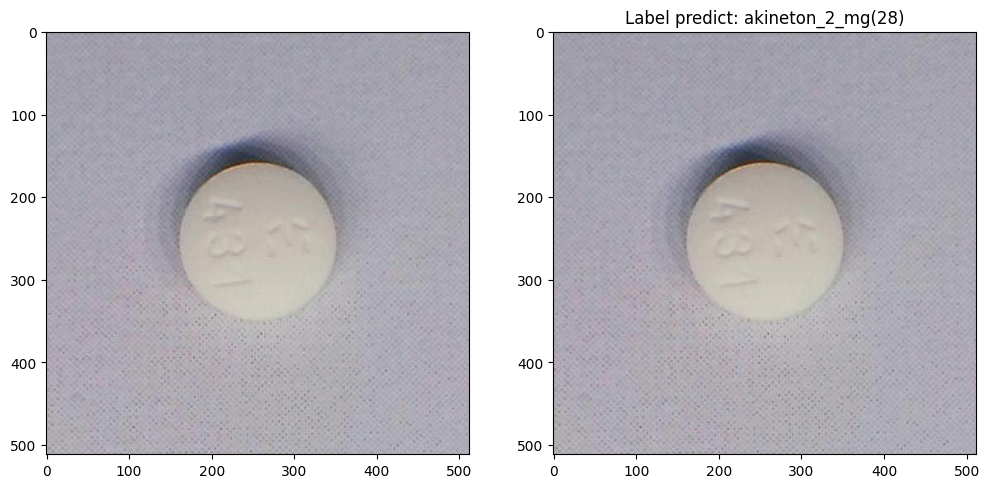

In [ ]:
#Trực quan hoá dữ liệu gốc (ảnh + nhãn) và kết quả dự đoán (predict)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(x_test[index], cmap='Greys')
# strTitle = 'Label:'
# strTitle = strTitle + format(y_test[index])
# strTitle = strTitle + '('+ format(index)+')'
# plt.title(strTitle)

plt.subplot(1,2,2)
plt.imshow(x_test[index], cmap='Greys')
strTitle = 'Label predict: '
strTitle = strTitle + format(y_pred[0])
strTitle = strTitle + '('+ format(index)+')'
plt.title(strTitle)

## In ra các hình ảnh phân loại sai

In [ ]:
# Dự đoán trên tập test
y_pred = svm.predict(X_test_scaled)

In [ ]:
# 1. Xác định các chỉ số bị phân loại sai
mis_idx = np.where(y_pred != y_test)[0]
print(f"Total misclassified: {len(mis_idx)} / {len(y_test)}")

Total misclassified: 11 / 30


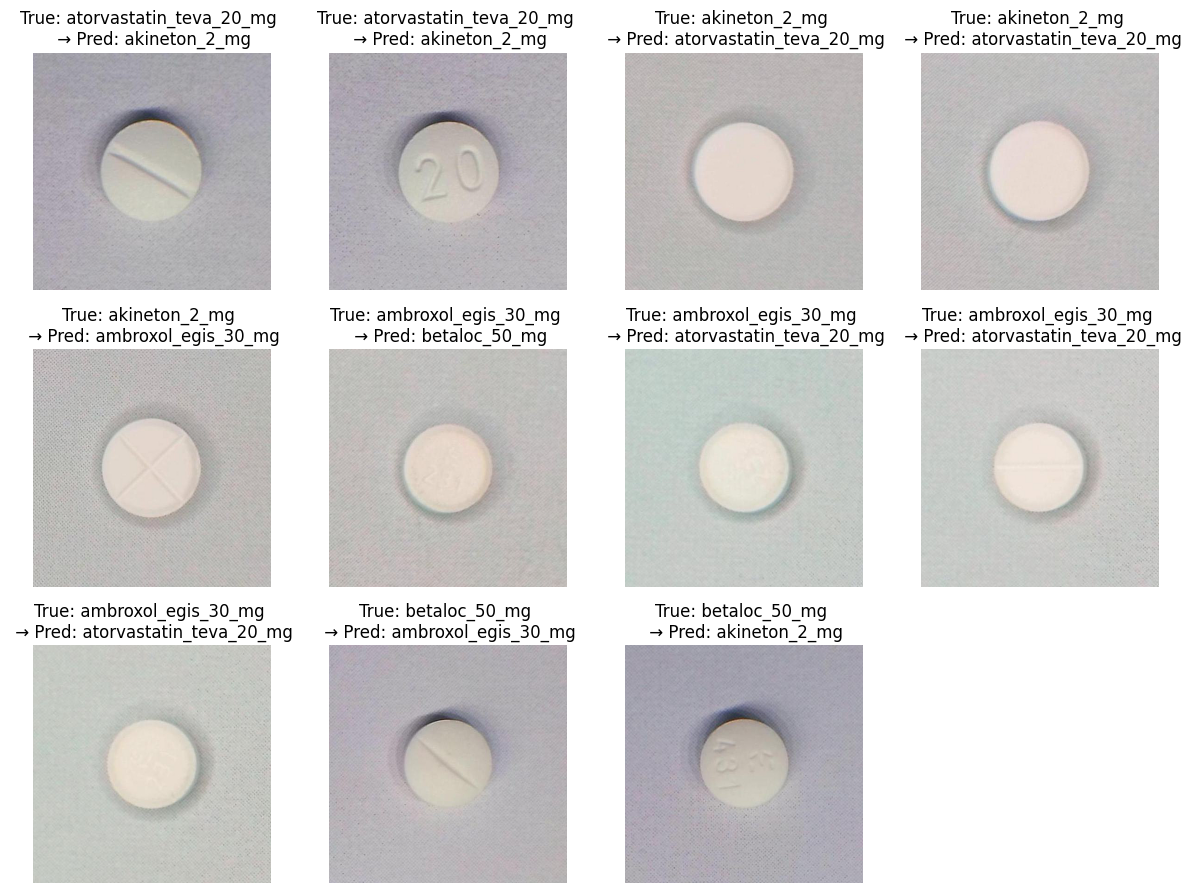

In [ ]:
# 2. Hiển thị một số ảnh sai (ví dụ 16 ảnh đầu)
num_to_show = min(16, len(mis_idx))
plt.figure(figsize=(12,12))

for i, idx in enumerate(mis_idx[:num_to_show]):
    plt.subplot(4, 4, i+1)
    # Hiển thị ảnh gốc
    plt.imshow(x_test[idx], cmap=None)   # nếu ảnh màu dùng cmap=None
    plt.title(f"True: {y_test[idx]} \n → Pred: {y_pred[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Bài toán 07: thử kết quả trên cấu hình  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

## Huấn luyện mô hình

In [ ]:
# Bước 2: Chuẩn hóa dữ liệu (SVM yêu cầu dữ liệu chuẩn hóa)
scaler = StandardScaler()

In [ ]:
# Chuẩn hóa tập huấn luyện và tập kiểm tra
X_train_scaled = scaler.fit_transform(X_train)  # Chuẩn hóa tập huấn luyện
X_test_scaled = scaler.transform(X_test)  # Chuẩn hóa tập kiểm tra

In [ ]:
from sklearn.svm import SVC

# Huấn luyện mô hình SVM (hoặc mô hình khác)
svm = SVC(kernel='rbf', gamma = 'scale', C=10)
svm.fit(X_train_scaled, y_train)

SVC(C=10)

## Plot tập rút trích của tập train sau khi qua mô hình SVM với kernel {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.decomposition import PCA
# from sklearn.svm import SVC

# # Giả sử bạn đã có X_train, y_train, X_test, y_test
# # Mã hóa nhãn nếu cần
# # label_encoder = LabelEncoder().fit(y_train)
# y_encoded = LabelEncoder().fit_transform(y_train)

# # 1. Chuẩn hóa dữ liệu
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # 2. PCA xuống 2D
# pca = PCA(n_components=2)
# X_train_2d = pca.fit_transform(X_train_scaled)

# # 3. Huấn luyện SVM với cấu hình cố định
# params = {'C': 10, 'kernel': 'rbf', 'gamma': 'scale'}
# svm = SVC(**params)
# svm.fit(X_train_2d, y_encoded)

# # 4. Tạo lưới để vẽ decision boundary
# x_min, x_max = X_train_2d[:,0].min() - 10, X_train_2d[:,0].max() + 10
# y_min, y_max = X_train_2d[:,1].min() - 10, X_train_2d[:,1].max() + 10
# xx, yy = np.meshgrid(
#     np.linspace(x_min, x_max, 500),
#     np.linspace(y_min, y_max, 500)
# )
# grid = np.c_[xx.ravel(), yy.ravel()]

# # 5. Dự đoán nhãn trên lưới
# Z = svm.predict(grid).reshape(xx.shape)

# # 6. Plot decision boundary và scatter
# fig, ax = plt.subplots(figsize=(6,5))

# # Màu sắc
# colors = ['#D62728', '#1F77B4', '#2CA02C', '#FF7F0E', '#9467BD']
# cmap_light = ListedColormap(colors)

# # Vùng phân lớp
# ax.contourf(xx, yy, Z, alpha=0.2, cmap=cmap_light)

# # Scatter
# scatter = ax.scatter(
#     X_train_2d[:,0], X_train_2d[:,1],
#     c=y_encoded, cmap=ListedColormap(colors),
#     edgecolor='k', s=60, alpha=0.9
# )

# # Legend chỉ số lớp
# ax.legend(*scatter.legend_elements(), loc='upper right', title='Class')

# # Thiết lập
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
# ax.set_title("Gabor feature with SVM (C=10, kernel='rbf', gamma='scale') Decision Boundary")
# ax.grid(True, linestyle='--', linewidth=0.5)
# plt.tight_layout()
# plt.show()

## Kiểm thử kết quả trên tập train

In [ ]:
# Dự đoán trên tập train
y_pred = svm.predict(X_train_scaled)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# In classification report
print(classification_report(y_train, y_pred))

                         precision    recall  f1-score   support

          akineton_2_mg       0.97      0.85      0.91        34
       algopyrin_500_mg       1.00      1.00      1.00        34
    ambroxol_egis_30_mg       0.96      0.68      0.79        34
atorvastatin_teva_20_mg       0.73      0.97      0.84        34
          betaloc_50_mg       0.76      0.82      0.79        34

               accuracy                           0.86       170
              macro avg       0.88      0.86      0.86       170
           weighted avg       0.88      0.86      0.86       170



In [ ]:
# In độ chính xác
print("Accuracy:", accuracy_score(y_train, y_pred))

Accuracy: 0.8647058823529412


## Kiểm thử kết quả trên tập test

In [ ]:
# Dự đoán trên tập test
y_pred = svm.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# In classification report
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

          akineton_2_mg       1.00      0.83      0.91         6
       algopyrin_500_mg       1.00      1.00      1.00         6
    ambroxol_egis_30_mg       1.00      0.83      0.91         6
atorvastatin_teva_20_mg       0.75      1.00      0.86         6
          betaloc_50_mg       0.83      0.83      0.83         6

               accuracy                           0.90        30
              macro avg       0.92      0.90      0.90        30
           weighted avg       0.92      0.90      0.90        30



In [ ]:
# Tính các độ đo trên tập test
accuracy_test = accuracy_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall_test = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1_test = f1_score(y_test, y_pred, average='weighted', zero_division=1)

print(f"Test Accuracy: {accuracy_test * 100:.2f}%")
print(f"Test Precision: {precision_test:.2f}")
print(f"Test Recall: {recall_test:.2f}")
print(f"Test F1 Score: {f1_test:.2f}")

Test Accuracy: 90.00%
Test Precision: 0.92
Test Recall: 0.90
Test F1 Score: 0.90


## Kiểm thử model

In [ ]:
import os
from glob import glob
image_path = "/content/drive/MyDrive/CS231/Đồ án/Thuoc/preprocessed/test/betaloc_50_mg/038.png"
# Tạo danh sách đường dẫn ảnh test
test_dir = "/content/drive/MyDrive/CS231/Đồ án/Thuoc/preprocessed/test"
X_test_paths = sorted(glob(os.path.join(test_dir, "*", "*.png")))  # tìm trong các thư mục con

# Tìm chỉ số của ảnh này trong danh sách đường dẫn
index = X_test_paths.index(image_path)

# Dự đoán ảnh tại chỉ số đó
y_pred = svm.predict(X_test_scaled[index:index+1])

Text(0.5, 1.0, 'Label predict: betaloc_50_mg(28)')

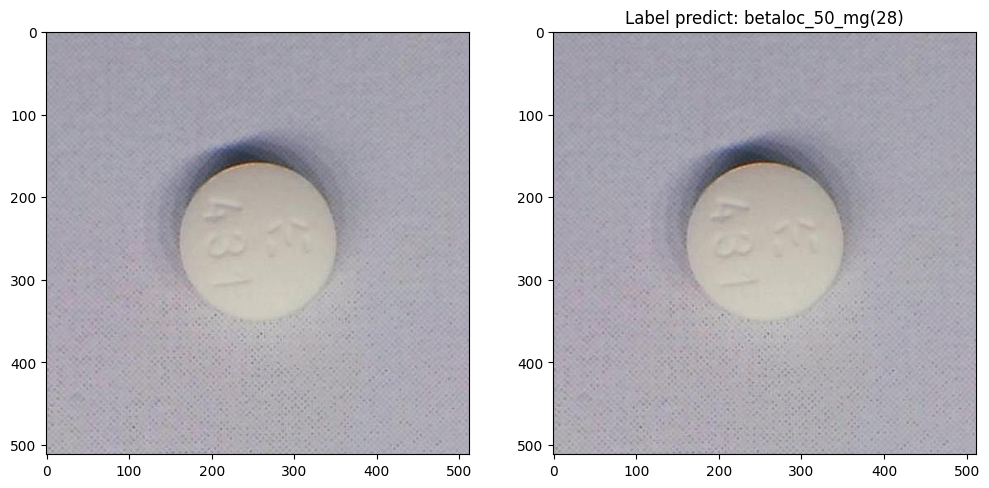

In [ ]:
#Trực quan hoá dữ liệu gốc (ảnh + nhãn) và kết quả dự đoán (predict)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(x_test[index], cmap='Greys')
# strTitle = 'Label:'
# strTitle = strTitle + format(y_test[index])
# strTitle = strTitle + '('+ format(index)+')'
# plt.title(strTitle)

plt.subplot(1,2,2)
plt.imshow(x_test[index], cmap='Greys')
strTitle = 'Label predict: '
strTitle = strTitle + format(y_pred[0])
strTitle = strTitle + '('+ format(index)+')'
plt.title(strTitle)

## In ra các hình ảnh phân loại sai

In [ ]:
# Dự đoán trên tập test
y_pred = svm.predict(X_test_scaled)

In [ ]:
# 1. Xác định các chỉ số bị phân loại sai
mis_idx = np.where(y_pred != y_test)[0]
print(f"Total misclassified: {len(mis_idx)} / {len(y_test)}")

Total misclassified: 3 / 30


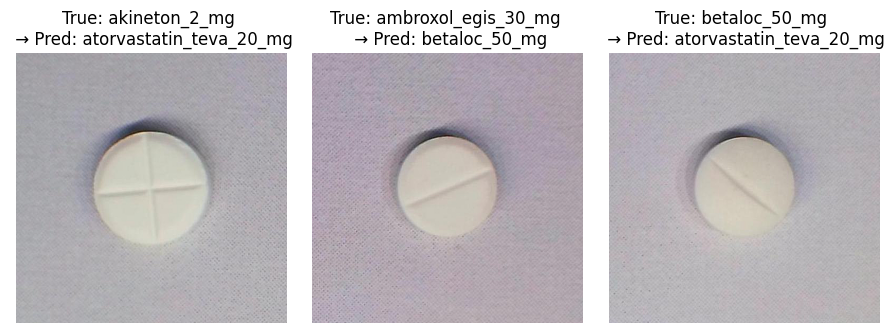

In [ ]:
# 2. Hiển thị một số ảnh sai (ví dụ 16 ảnh đầu)
num_to_show = min(16, len(mis_idx))
plt.figure(figsize=(12,12))

for i, idx in enumerate(mis_idx[:num_to_show]):
    plt.subplot(4, 4, i+1)
    # Hiển thị ảnh gốc
    plt.imshow(x_test[idx], cmap=None)   # nếu ảnh màu dùng cmap=None
    plt.title(f"True: {y_test[idx]} \n → Pred: {y_pred[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Bài toán 08: thử kết quả trên cấu hình  {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}

## Huấn luyện mô hình

In [ ]:
# Bước 2: Chuẩn hóa dữ liệu (SVM yêu cầu dữ liệu chuẩn hóa)
scaler = StandardScaler()

In [ ]:
# Chuẩn hóa tập huấn luyện và tập kiểm tra
X_train_scaled = scaler.fit_transform(X_train)  # Chuẩn hóa tập huấn luyện
X_test_scaled = scaler.transform(X_test)  # Chuẩn hóa tập kiểm tra

In [ ]:
from sklearn.svm import SVC

# Huấn luyện mô hình SVM (hoặc mô hình khác)
svm = SVC(kernel='rbf', gamma = 'scale', C=100)
svm.fit(X_train_scaled, y_train)

SVC(C=100)

## Plot tập rút trích của tập train sau khi qua mô hình SVM với kernel {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.decomposition import PCA
# from sklearn.svm import SVC

# # Giả sử bạn đã có X_train, y_train, X_test, y_test
# # Mã hóa nhãn nếu cần
# # label_encoder = LabelEncoder().fit(y_train)
# y_encoded = LabelEncoder().fit_transform(y_train)

# # 1. Chuẩn hóa dữ liệu
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # 2. PCA xuống 2D
# pca = PCA(n_components=2)
# X_train_2d = pca.fit_transform(X_train_scaled)

# # 3. Huấn luyện SVM với cấu hình cố định
# params = {'C': 10, 'kernel': 'rbf', 'gamma': 'scale'}
# svm = SVC(**params)
# svm.fit(X_train_2d, y_encoded)

# # 4. Tạo lưới để vẽ decision boundary
# x_min, x_max = X_train_2d[:,0].min() - 10, X_train_2d[:,0].max() + 10
# y_min, y_max = X_train_2d[:,1].min() - 10, X_train_2d[:,1].max() + 10
# xx, yy = np.meshgrid(
#     np.linspace(x_min, x_max, 500),
#     np.linspace(y_min, y_max, 500)
# )
# grid = np.c_[xx.ravel(), yy.ravel()]

# # 5. Dự đoán nhãn trên lưới
# Z = svm.predict(grid).reshape(xx.shape)

# # 6. Plot decision boundary và scatter
# fig, ax = plt.subplots(figsize=(6,5))

# # Màu sắc
# colors = ['#D62728', '#1F77B4', '#2CA02C', '#FF7F0E', '#9467BD']
# cmap_light = ListedColormap(colors)

# # Vùng phân lớp
# ax.contourf(xx, yy, Z, alpha=0.2, cmap=cmap_light)

# # Scatter
# scatter = ax.scatter(
#     X_train_2d[:,0], X_train_2d[:,1],
#     c=y_encoded, cmap=ListedColormap(colors),
#     edgecolor='k', s=60, alpha=0.9
# )

# # Legend chỉ số lớp
# ax.legend(*scatter.legend_elements(), loc='upper right', title='Class')

# # Thiết lập
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
# ax.set_title("Gabor feature with SVM (C=10, kernel='rbf', gamma='scale') Decision Boundary")
# ax.grid(True, linestyle='--', linewidth=0.5)
# plt.tight_layout()
# plt.show()

## Kiểm thử kết quả trên tập train

In [ ]:
# Dự đoán trên tập train
y_pred = svm.predict(X_train_scaled)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# In classification report
print(classification_report(y_train, y_pred))

                         precision    recall  f1-score   support

          akineton_2_mg       0.97      0.88      0.92        34
       algopyrin_500_mg       1.00      1.00      1.00        34
    ambroxol_egis_30_mg       0.90      0.79      0.84        34
atorvastatin_teva_20_mg       0.86      0.94      0.90        34
          betaloc_50_mg       0.74      0.82      0.78        34

               accuracy                           0.89       170
              macro avg       0.89      0.89      0.89       170
           weighted avg       0.89      0.89      0.89       170



In [ ]:
# In độ chính xác
print("Accuracy:", accuracy_score(y_train, y_pred))

Accuracy: 0.888235294117647


## Kiểm thử kết quả trên tập test

In [ ]:
# Dự đoán trên tập test
y_pred = svm.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# In classification report
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

          akineton_2_mg       1.00      1.00      1.00         6
       algopyrin_500_mg       1.00      1.00      1.00         6
    ambroxol_egis_30_mg       1.00      0.83      0.91         6
atorvastatin_teva_20_mg       1.00      1.00      1.00         6
          betaloc_50_mg       0.86      1.00      0.92         6

               accuracy                           0.97        30
              macro avg       0.97      0.97      0.97        30
           weighted avg       0.97      0.97      0.97        30



In [ ]:
# Tính các độ đo trên tập test
accuracy_test = accuracy_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall_test = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1_test = f1_score(y_test, y_pred, average='weighted', zero_division=1)

print(f"Test Accuracy: {accuracy_test * 100:.2f}%")
print(f"Test Precision: {precision_test:.2f}")
print(f"Test Recall: {recall_test:.2f}")
print(f"Test F1 Score: {f1_test:.2f}")

Test Accuracy: 96.67%
Test Precision: 0.97
Test Recall: 0.97
Test F1 Score: 0.97


## Kiểm thử model

In [ ]:
import os
from glob import glob
image_path = "/content/drive/MyDrive/CS231/Đồ án/Thuoc/preprocessed/test/betaloc_50_mg/038.png"
# Tạo danh sách đường dẫn ảnh test
test_dir = "/content/drive/MyDrive/CS231/Đồ án/Thuoc/preprocessed/test"
X_test_paths = sorted(glob(os.path.join(test_dir, "*", "*.png")))  # tìm trong các thư mục con

# Tìm chỉ số của ảnh này trong danh sách đường dẫn
index = X_test_paths.index(image_path)

# Dự đoán ảnh tại chỉ số đó
y_pred = svm.predict(X_test_scaled[index:index+1])

Text(0.5, 1.0, 'Label predict: betaloc_50_mg(28)')

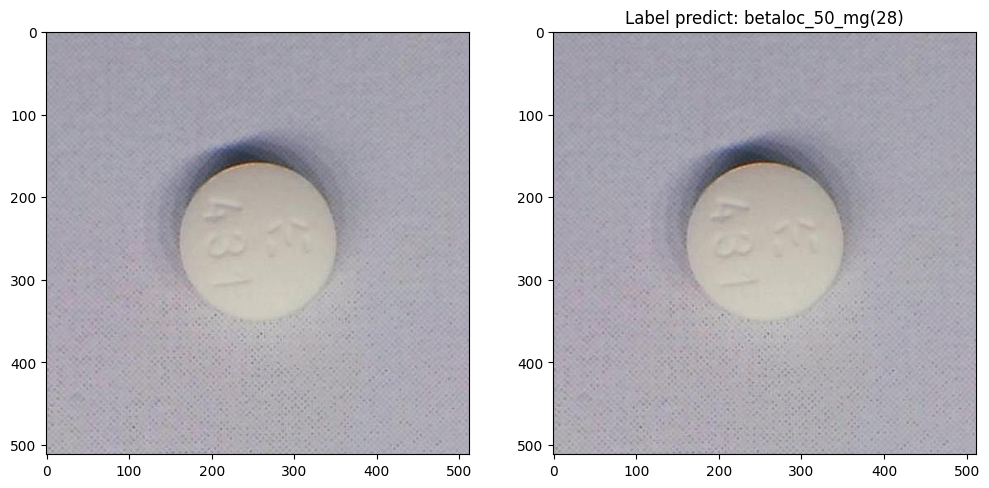

In [ ]:
#Trực quan hoá dữ liệu gốc (ảnh + nhãn) và kết quả dự đoán (predict)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(x_test[index], cmap='Greys')
# strTitle = 'Label:'
# strTitle = strTitle + format(y_test[index])
# strTitle = strTitle + '('+ format(index)+')'
# plt.title(strTitle)

plt.subplot(1,2,2)
plt.imshow(x_test[index], cmap='Greys')
strTitle = 'Label predict: '
strTitle = strTitle + format(y_pred[0])
strTitle = strTitle + '('+ format(index)+')'
plt.title(strTitle)

## In ra các hình ảnh phân loại sai

In [ ]:
# Dự đoán trên tập test
y_pred = svm.predict(X_test_scaled)

In [ ]:
# 1. Xác định các chỉ số bị phân loại sai
mis_idx = np.where(y_pred != y_test)[0]
print(f"Total misclassified: {len(mis_idx)} / {len(y_test)}")

Total misclassified: 1 / 30


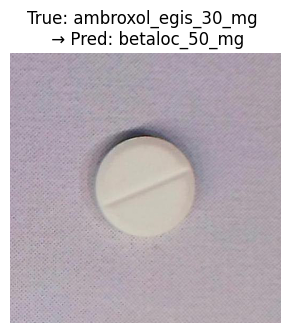

In [ ]:
# 2. Hiển thị một số ảnh sai (ví dụ 16 ảnh đầu)
num_to_show = min(16, len(mis_idx))
plt.figure(figsize=(12,12))

for i, idx in enumerate(mis_idx[:num_to_show]):
    plt.subplot(4, 4, i+1)
    # Hiển thị ảnh gốc
    plt.imshow(x_test[idx], cmap=None)   # nếu ảnh màu dùng cmap=None
    plt.title(f"True: {y_test[idx]} \n → Pred: {y_pred[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()